In [1]:
import pandas

countries_csv = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv"
cases_csv = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
deaths_csv = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

countries = pandas.read_csv(countries_csv)
cases = pandas.read_csv(cases_csv)
deaths = pandas.read_csv(deaths_csv)

In [2]:
last_col = cases.columns[-1]

cases_ch = cases[cases["Country/Region"] == "Switzerland"]
num_cases_ch = cases_ch[last_col]
cases_gt_ch = cases[cases[last_col] > int(num_cases_ch)]
cases_interest = cases_gt_ch.append(cases_ch).sort_values(by=last_col, ascending=False).set_index("Country/Region")

deaths_ch = deaths[deaths["Country/Region"] == "Switzerland"]
num_deaths_ch = deaths_ch[last_col]
deaths_gt_ch = deaths[deaths[last_col] > int(num_deaths_ch)]
deaths_interest = deaths_gt_ch.append(deaths_ch).sort_values(by=last_col, ascending=False).set_index("Country/Region")

In [3]:
# Show stats for this number of days, or None for all
num_days = 20

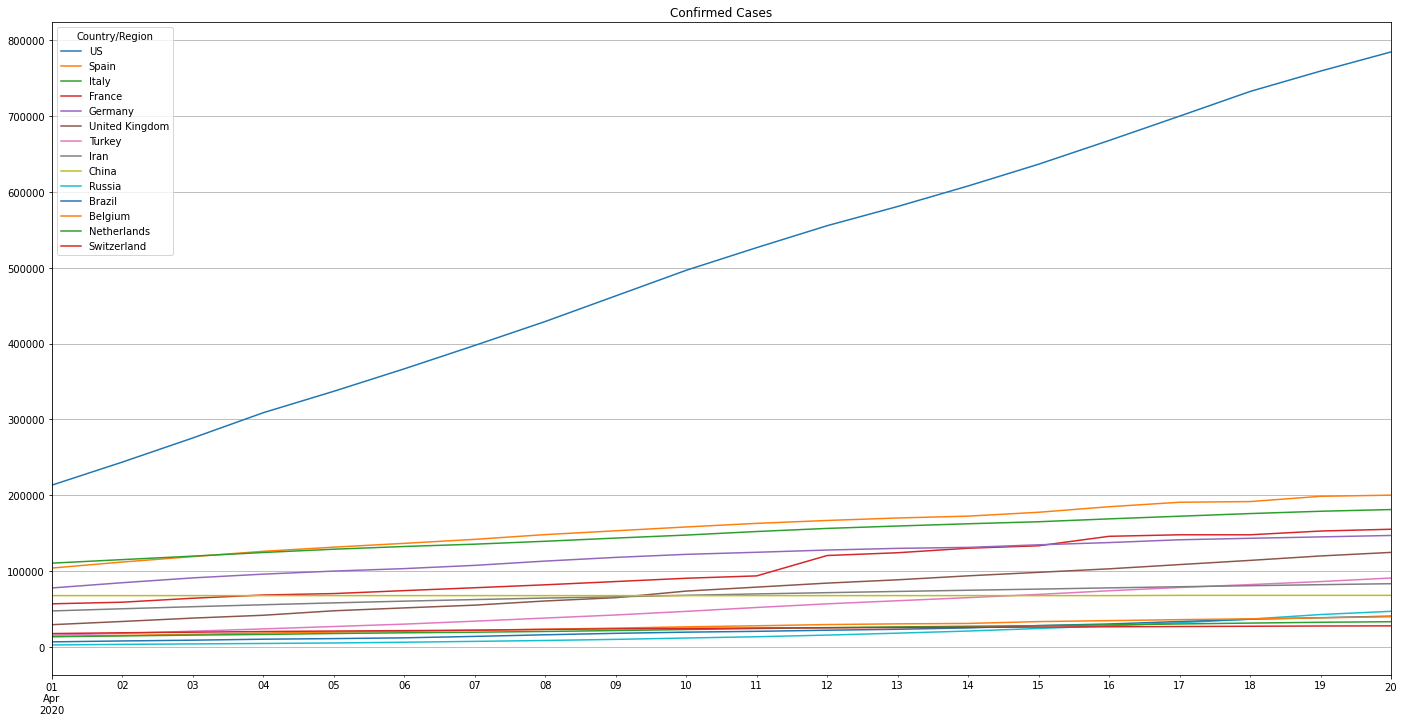

In [4]:
cases_trim = cases_interest.T.iloc[3:, :]

if num_days:
    cases_trim = cases_trim.iloc[-num_days:, :]

cases_trim.index = pandas.to_datetime(cases_trim.index)
cases_plot = cases_trim.plot(title="Confirmed Cases", figsize=(24, 12), grid=True)

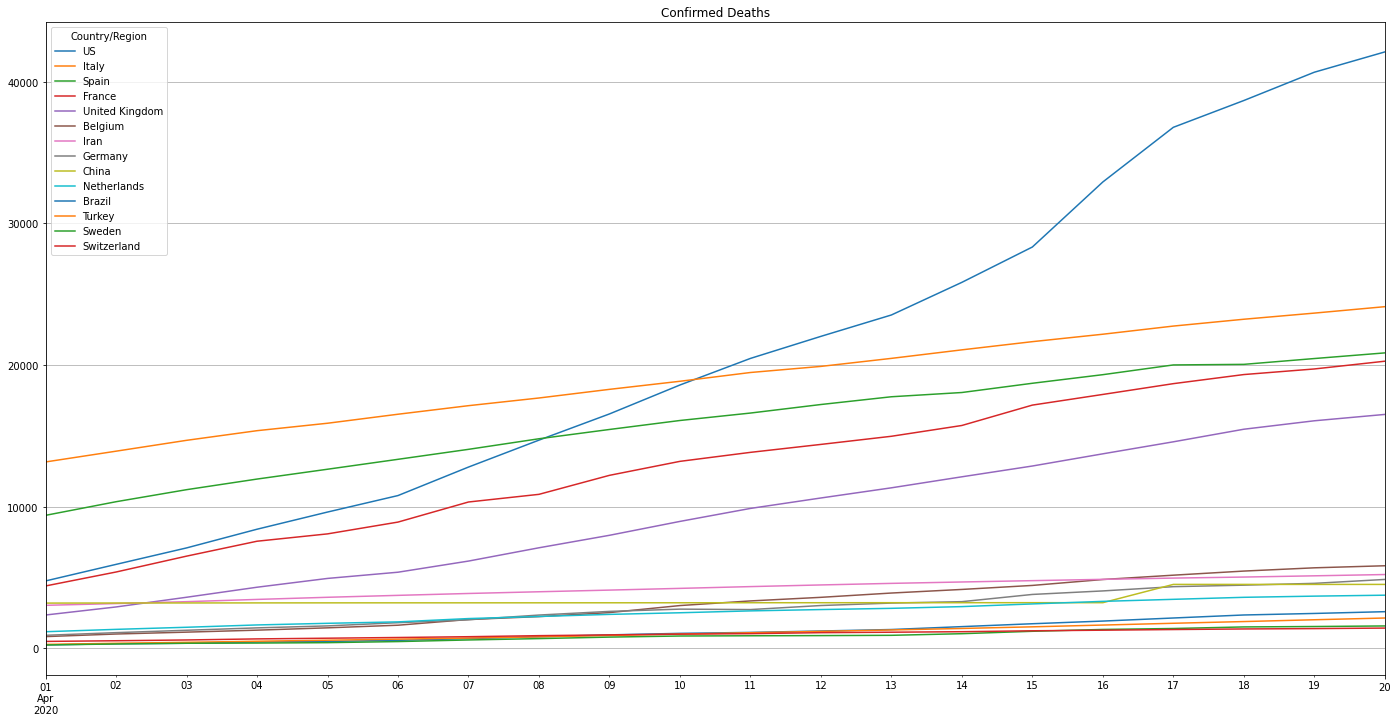

In [5]:
deaths_trim = deaths_interest.T.iloc[3:, :]

if num_days:
    deaths_trim = deaths_trim.iloc[-num_days:, :]

deaths_trim.index = pandas.to_datetime(deaths_trim.index)
deaths_plot = deaths_trim.plot(title="Confirmed Deaths", figsize=(24, 12), grid=True)

# TODO Figure out how to annotate the lines to see the final values
# for k, v in deaths_idx.iterrows():
#     print("Key: %s  Val: %s" % (k, v[-1]))
#     ax.annotate("blah blah", (-10, v[-1] / 10))


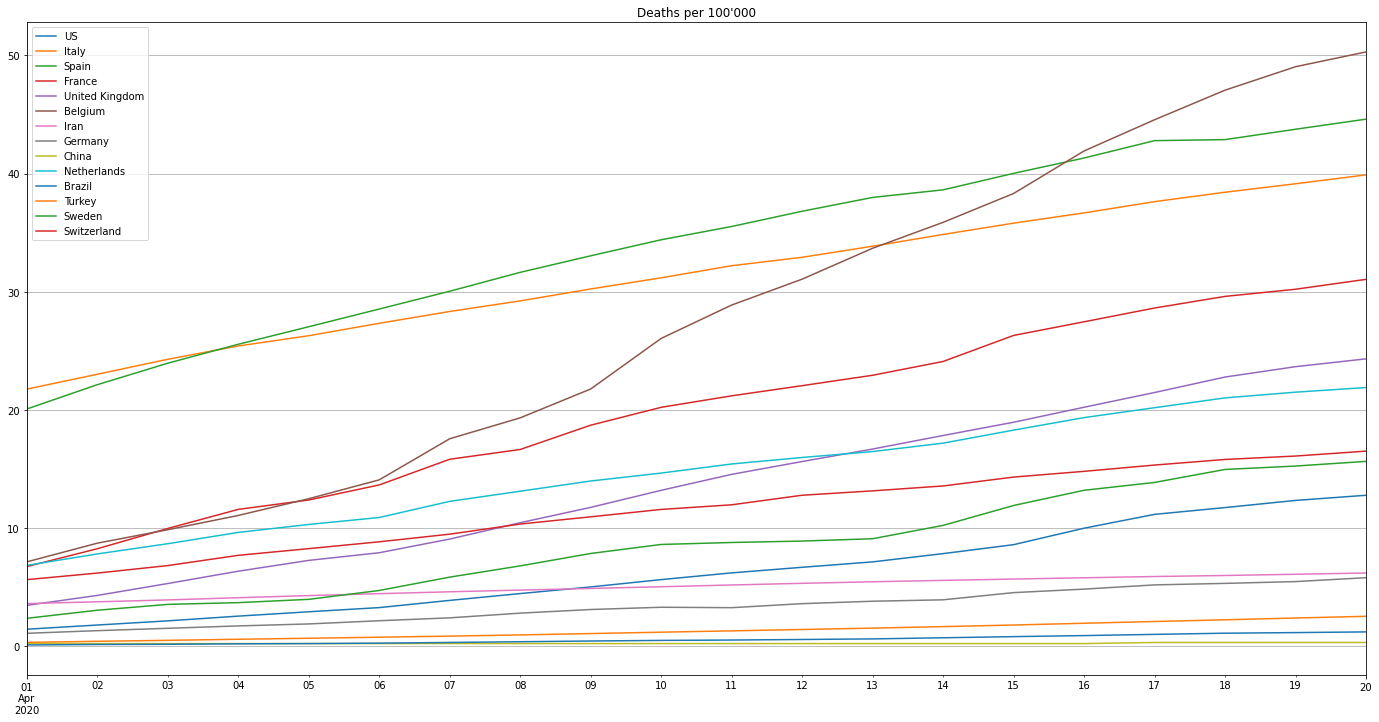

In [6]:
dpm = pandas.DataFrame()

for k, v in deaths_trim.items():
    pop = int(countries[countries["Combined_Key"] == k]["Population"])
    factor = 100000 / pop 
#     print(k, pop, factor)
    series = v.mul(factor)
    dpm = dpm.append(series)

dpm_plot = dpm.T.plot(title="Deaths per 100'000", figsize=(24, 12), grid=True)
